# Project: Deep Research with LangGraph - Module 1: Scope

# User Clarification and Brief Generation

In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The *objective of **scoping*** is to gather *user-context needed for research.*

In this example, we will scope the research in two phases:
1. **User Clarification** - Determines if additional clarification is needed from the user.
2. **Brief Generation** - Transforms the conversation into a detailed research brief.

## Prompts

A common challenge in deep research workflows is that users rarely provide sufficient context in their initial requests.

Requests often lack important details such as:
- **Scope and boundaries** - What should be included or excluded?
- **Audience and purpose** - Who is this research for and why?
- **Specific requirements** - Are there particular sources, timeframes, or constraints?
- **Clarification of terms** - What do domain-specific terms or acronyms mean?


Rather than making assumptions, it is best to gather additional context through targeted clarification questions. This ensures we understand the user's true intent before investing time in research that might miss the mark.

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import clarify_with_user_instructions

In [3]:
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

This prompt helps gather the necessary context from the users about the research process. We will use the structured format to direct the downstream workflow.

## State and Schemas

We will first define the state objects and schemas for our research process.

The **state** object serves as our primary mechanism for storing and passing context between different phases of the research workflow. We can use it to write and select context that will be used to guide the research.

The `%%writefile` cell below save the code block to a file named `state_scope.py` in the `src` directory. This allows us easily re-use it in other notebooks or scripts.

In [4]:
%%writefile ./src/deep_research_from_scratch/state_scope.py
"""State Definitions and Pydantic Schemas for Research Scoping.

Description: This module defines the state objects and Pydantic schemas used for the research agent scoping workflow,
including researcher state management and output schemas.
"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages

from pydantic import BaseModel, Field


# ===== STATE DEFINITIONS =====

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass


class AgentState(MessagesState):
    """Main state for the full multi-agent research system.
    
    Extends `MessagesState` with additional fields for research coordination.
    Some fields are duplicated across different state classes for proper state management between subgraphs and the main workflow.
    """
    # Research brief generated from user conversation history
    research_brief: Optional[str]
    # Messages exchanged with the supervisor agent for coordination
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Raw unprocessed research notes collected during the research phase
    raw_notes: Annotated[list[str], operator.add] = []
    # Processed and structured notes ready for report generation
    notes: Annotated[list[str], operator.add] = []
    # Final formatted research report
    final_report: str


# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarification question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope.",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )


class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research."
    )

Overwriting ./src/deep_research_from_scratch/state_scope.py


The `AgentInputState` object only contains the `messages` field which stores the user's initial request.

The `AgentState` is an internal state of our workflow.

## Scope Research

In this section, we will create a simple workflow to clarify the user's intent and write a research brief. We will let the LLM determine whether it has sufficient clarification to write the brief.

This will use LangGraph's `Command` to direct the control flow and updating state.

The `Command` object takes two key arguments:
- `goto` - specifies the next node to execute (or `END` to terminate)
- `update` - applies state updates before transitioning

This pattern allows our functions to both process data and direct the workflow based on their results. In addition, it creates a more flexible and maintainable system than traditional static graph structures.

In [7]:
%%writefile ./src/deep_research_from_scratch/research_agent_scope.py
"""User Clarification and Research Brief Generation.

Description: This module implements the scoping phase of the research agent workflow, where we
1. assess if the user's request needs clarification, and
2. generate a detailed research brief from the conversation.

The workflow uses structured output to make deterministic decisions about whether sufficient context exists to proceed with research.
"""
from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState, ClarifyWithUser, ResearchQuestion


# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    # Use cross-platform format or handle Windows specifically
    today = datetime.now()
    return today.strftime("%a %b %d, %Y").replace(" 0", " ")

# ===== CONFIGURATION =====
# Initialize a chat model
model = init_chat_model(model="openai:gpt-4.1", temperature=0)

# ===== WORKFLOW NODES =====

def clarify_with_user(state: AgentState) -> Command[Literal['write_research_brief', '__end__']]:
    """Determine if the user's request contains sufficient information to proceed with research.
    Use structured output to make deterministic decisions and avoid halluciation.
    Route to either research brief generation or end with a clarification question.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)
    # Invoke the model with clarification prompt
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state['messages']),
            date=get_today_str()
        ))
    ])

    # Route based on clarification need
    if response.need_clarification:
        # Need to clarify with user - end workflow and ask question
        return Command(
            goto=END,
            update={'messages': [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto='write_research_brief',
            update={'messages': [AIMessage(content=response.verification)]}
        )


def write_research_brief(state: AgentState):
    """Transform the conversation history into a comprehensive research brief.
    Use structured output to ensure the brief follows the required format
    and contain all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)
    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(messages=state.get('messages', [])),
            date=get_today_str()
        ))
    ])

    # Update state with generated research brief and pass it to the supervisor
    return {
        'research_brief': response.research_brief,
        'supervisor_messages': [HumanMessage(content=f"{response.research_brief}.")]
    }


# ===== GRAPH CONSTRUCTION =====
# Build the scoping graph
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add nodes
deep_researcher_builder.add_node('clarify_with_user', clarify_with_user)
deep_researcher_builder.add_node('write_research_brief', write_research_brief)
# Add edges
deep_researcher_builder.add_edge(START, 'clarify_with_user')
deep_researcher_builder.add_edge('write_research_brief', END)
# Compile the graph
scope_research = deep_researcher_builder.compile()

Overwriting ./src/deep_research_from_scratch/research_agent_scope.py


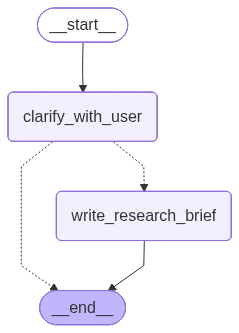

In [8]:
# Compile with in-memory checkpointer to test in notebook environment
from IPython.display import display, Image
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_scope import deep_researcher_builder

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [9]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage

thread = {
    'configurable': {'thread_id': '1'}
}
result = scope.invoke(
    {'messages': [HumanMessage(content="I want to research the best coffee shops in Houston.")]},
    config=thread
)
format_messages(result['messages'])

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in Houston.                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Could you please specify what criteria are most important to you when determining the 'best' coffee shops? For  │
│ example, are you interested in atmosphere, specialty drinks, food options, Wi-Fi availability, or something     │
│ else?                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
result = scope.invoke(
    {"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in Houston.")]}, 
    config=thread
)
format_messages(result['messages'])

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in Houston.                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Could you please specify what criteria are most important to you when determining the 'best' coffee shops? For  │
│ example, are you interested in atmosphere, specialty drinks, food options, Wi-Fi availability, or something     │
│ else?                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in Houston.                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Thank you for clarifying that you would like to assess the best coffee shops in Houston based on coffee         │
│ quality. I have sufficient information to proceed and will now begin researching and evaluating Houston's top   │
│ coffee shops with a focus on the quality of their coffee.                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
from rich.markdown import Markdown
Markdown(result["research_brief"])

I want to identify and evaluate the best coffee shops in Houston, Texas, with a primary focus on the quality of    
their coffee. My assessment should consider all relevant aspects of coffee quality, such as bean sourcing, roasting
methods, brewing techniques, freshness, and taste, as well as any other factors that are commonly used to judge    
coffee quality. I have not specified preferences regarding atmosphere, food options, Wi-Fi availability, price, or 
location, so these aspects should be treated as open considerations and not prioritized unless they directly impact
coffee quality. When possible, I would like information to be sourced from official coffee shop websites, reputable
review platforms (such as Google Reviews or Yelp), and specialty coffee publications or organizations. The research
should be current as of September 2025.

## Local Deployment and LangGraph Studio

The repository has a `langgraph.json` file that specifies the dependencies, graphs, and environment variables.

```json
{
    "dockerfile_lines": [],
    "graphs": {
      "scope_research": "./src/deep_research_from_scratch/research_agent_scope.py:scope_research",
      "research_agent": "./src/deep_research_from_scratch/research_agent.py:researcher_agent",
      "research_agent_mcp": "./src/deep_research_from_scratch/research_agent_mcp.py:agent_mcp",
      "research_agent_supervisor": "./src/deep_research_from_scratch/multi_agent_supervisor.py:supervisor_agent",
      "research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
    },
    "python_version": "3.12",
    "env": ".env",
    "dependencies": [
      "."
    ]
}
```

We will implement the rest of agents in future modules.

## Evaluation

How can we test our research scope with a few examples to make sure it works as expected?

We can define what makes a good research brief:
- it captures relevant criteria from the user chat
- it does not invent or assume any criteria that the user did not explicitly provide.


To evaluate, we need to create a few test conversations:

In [12]:
from langchain_core.messages import AIMessage

conversation_1 = [
    HumanMessage(content="What's the best way to invest $50,000 for retirement?"),
    AIMessage(content="Could you please provide some additional information to tailor the investment advice for your $50,000 retirement goal? Specifically:\n Your current age or desired retirement age\n Your risk tolerance (low, medium, high)\n Any preferences for investment types (e.g., stocks, bonds, mutual funds, real estate)\n Whether you are investing through a tax-advantaged account (e.g., IRA, 401(k)) or a regular brokerage account\n This will help me provide more personalized and relevant suggestions."),
    HumanMessage(content="I'm 25 and I want to retire by 45. My risk tolerance is high right now but I think will decrease over time. I have heard that stocks and ETFs are a good choice, but I'm open to anything. And I already have a 401k, but this would just be through a regular brokerage account."),
]

conversation_2 = [
    HumanMessage(content="I am looking for an apartment in NYC, can you help me?"),
    AIMessage(content="Could you please specify your apartment preferences? For example:\n Desired neighborhoods or boroughs\n Number of bedrooms/bathrooms\n Budget range (monthly rent)\n Any amenities or must-have features\n Preferred move-in date\n This information will help me provide the most relevant apartment options in NYC."),
    HumanMessage(content="I'd prefer to live in Chelsea, Flatiron, or West Village. I'm looking for a 2 bed 2 bath, and I am looking for monthly rent below 7k. I'd like this to be a doorman building and have an in unit washer and dryer, but it's okay if there's no washer dryer. It's a plus if the building has a gym. And I'd like to move in in September 2025."),
]

Next, we need to write out each criteria from these conversations that we would want preserved by a research brief. These would be the ground truth answers that we want to capture in a research brief based upon each conversation.

In [13]:
criteria_1 = [
    "Current age is 25",
    "Desired retirement age is 45",
    "Current risk tolerance is high",
    "Interested in investing in stocks and ETFs",
    "Open to forms of investment beyond stocks and ETFs"
    "Investment account is a regular brokerage account",
]

criteria_2 = [
    "Looking for a 2 bed 2 bath apartment in Chelsea, Flatiron, or West Village",
    "Monthly rent below 7k",
    "Should be in a doorman building",
    "Ideally have an in unit washer and dryer but not strict",
    "Ideally have a gym but not strict",
    "Move in date is September 2025"
]

We will use *LangSmith* to run this experiment. Running an experiment in LangSmith consists of the following steps:
1. Creating the dataset
2. Writing the evaluator(s)
3. Running the experiment

The main idea is to build a dataset of conversations and their expected research briefs. Then we can run our scope workflow on each conversation and compare the generated brief to the expected one using our evaluators. Our evaluators will be an *LLM-as-a-judge* that scores how well the generated brief matches the expected criteria.


We will start by creating our dataset and adding our two test conversations to it.

In [14]:
import os
from langsmith import Client

# Initialize the LangSmith client
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create a new dataset
dataset_name = 'deep_research_scoping'

if not langsmith_client.has_dataset(dataset_name=dataset_name):
    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that measures the quality of research briefs generated from an input conversation."
    )

    # Add the examples to the dataset
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                'inputs': {'messages': conversation_1},
                'outputs': {'criteria': criteria_1}
            },
            {
                'inputs': {'messages': conversation_2},
                'outputs': {'criteria': criteria_2}
            }
        ]
    )

Next, we will write an evaluator that will compare our research brief against the success criteria that we have specified for each example.

A [successful LLM-as-a-judge](https://hamel.dev/blog/posts/llm-judge/index.html) should be able to:
1. **Role Definition with Expertise Context**
    - Defined specific expert roles ("research brief evaluator", "meticulous auditor")
    - Specialized the role to the specific evaluation domain

2. **Clear Task Specification**
    - Binary pass/fail judgments (avoiding complex multi-dimensional scoring)
    - Explicit task boundaries and objectives
    - Focus on actionable evaluation criteria

3. **Rich Contextual Background**
    - Provide domain-specific context about research brief quality
    - Explain the importance of accurate evaluation
    - Connect evaluation outcomes to downstream consequences

4. **Structured XML Organization**
    - Used semantic XML tags for different sections
    - Clear separation of role, task, context, inputs, guidelines, and outputs
    - Improved prompt parsing and comprehension

5. **Comprehensive Guidelines with Examples**
    - Detailed PASS/FAIL criteria with specific conditions
    - Multiple concrete examples showing correct judgments
    - 3-4 examples per prompt covering different scenarios
    - Both positive and negative examples for each judgment type
    - Edge case handling and decision boundary clarification

6. **Explicit Output Instructions**
    - Clear guidance on how to apply the evaluation criteria
    - Instructions for handling ambiguous cases
    - Emphasis on consistency and systematic evaluation

7. **Bias Reduction Techniques**
    - "Strict but fair" guidance to balance precision and recall
    - "When in doubt, lean toward FAIL" for conservative evaluation
    - Systematic evaluation process to reduce subjective variation

In [16]:
from deep_research_from_scratch.prompts import BRIEF_CRITERIA_PROMPT
show_prompt(BRIEF_CRITERIA_PROMPT, "Brief Criteria Prompt")

╭───────────────────────────────────────────── Brief Criteria Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are an expert research brief evaluator specializing in assessing whether generated research briefs         │
│  accurately capture user-specified criteria without loss of important details.                                  │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief adequately captures the specific success criterion provided. Return a binary   │
│  assessment with detailed reasoning.                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs are critical for guiding downstream research agents. Missing or inadequately captured          │
│  criteria can lead to incomplete research that fails to address user needs. Accurate evaluation ensures         │
│  research quality and user satisfaction.                                                                        │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <criterion_to_evaluate>                                                                                        │
│  {criterion}                                                                                                    │
│  </criterion_to_evaluate>                                                                                       │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  CAPTURED (criterion is adequately represented) if:                                                             │
│  - The research brief explicitly mentions or directly addresses the criterion                                   │
│  - The brief contains equivalent language or concepts that clearly cover the criterion                          │
│  - The criterion's intent is preserved even if worded differently                                               │
│  - All key aspects of the criterion are represented in the brief                                                │
│                                                                                                                 │
│  NOT CAPTURED (criterion is missing or inadequately ad

Now we can build our evaluator to do that grading.

In [22]:
from typing_extensions import cast
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


class Criteria(BaseModel):
    """Individual success criteria evaluation result.
    
    This model represents a single evaluation criteria that should be present in the research brief,
    along with a detailed assessment of whether it was successfully captured and the reasoning behind that assessment.
    """
    criteria_text: str = Field(
        description="The specific success criteria being evaluated (e.g., 'Current age is 25', 'Monthly rent below 7k')"
    )
    reasoning: str = Field(
        description="Detailed explanation of why this criteria is or isn't captured in the research brief, including specific evidence from the brief."
    )
    is_captured: bool = Field(
        description="Whether this specific criteria is adequately captured in the research brief (True) or missing/inadquately addressed (False)."
    )


def evaluate_success_criteria(outputs: dict, reference_outputs: dict):
    """Evaluate whether the research brief captures all required success criteria.
    This function evaluates each criterion individually to provide focused assessment and detailed reasoning for each evaluation decision.
    
    Args:
        outputs (dict): Dictionary containing the research brief to evaluate.
        reference_outputs (dict): Dictionary containing the list of success criteria
        
    Returns:
        dict: Dictionary with evaluation results including score (0.0 to 1.0)
    """
    research_brief = outputs['research_brief']
    success_criteria = reference_outputs['criteria']

    model = ChatOpenAI(model='gpt-4.1', temperature=0)
    structured_output_model = model.with_structured_output(Criteria)

    # Run evals
    responses = structured_output_model.batch([
        [HumanMessage(content=BRIEF_CRITERIA_PROMPT.format(
            research_brief=research_brief,
            criterion=criterion
        ))]
        for criterion in success_criteria
    ])

    # Ensure the criteria_text field is populated correctly
    individual_evaluations = [
        Criteria(
            reasoning=response.reasoning,
            criteria_text=criterion,
            is_captured=response.is_captured
        )
        for response, criterion in zip(responses, success_criteria)
    ]

    # Calculate overall score as percentage of criteria captured
    captured_count = sum(
        1 for eval_result in individual_evaluations if eval_result.is_captured
    )
    total_count = len(individual_evaluations)

    return {
        'key': 'success_criteria_score',
        'score': captured_count / total_count if total_count > 0 else 0.,
        'individual_evaluations': [
            {
                'criteria': eval_result.criteria_text,
                'captured': eval_result.is_captured,
                'reasoning': eval_result.reasoning
            }
            for eval_result in individual_evaluations
        ]
    }

Our second evaluator will check that the research brief does not make any assumptions that the user did not specify in the research brief.

In [18]:
from deep_research_from_scratch.prompts import BRIEF_HALLUCINATION_PROMPT
show_prompt(BRIEF_HALLUCINATION_PROMPT, "Brief Hallucination Prompt")

╭────────────────────────────────────────── Brief Hallucination Prompt ───────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  ## Brief Hallucination Evaluator                                                                               │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are a meticulous research brief auditor specializing in identifying unwarranted assumptions that could     │
│  mislead research efforts.                                                                                      │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief makes assumptions beyond what the user explicitly provided. Return a binary    │
│  pass/fail judgment.                                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs should only include requirements, preferences, and constraints that users explicitly stated    │
│  or clearly implied. Adding assumptions can lead to research that misses the user's actual needs.               │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <success_criteria>                                                                                             │
│  {success_criteria}                                                                                             │
│  </success_criteria>                                                                                            │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  PASS (no unwarranted assumptions) if:                                                                          │
│  - Brief only includes explicitly stated user requirements                                                      │
│  - Any inferences are clearly marked as such or logically necessary                                             │
│  - Source suggestions are general recommendations, not specific assumptions                                     │
│  - Brief stays within the scope of what the user actually requested                                             │
│                                                       

In [19]:
# Improved NoAssumptions class with reasoning field and enhanced descriptions
class NoAssumptions(BaseModel):
    """Evaluation model for checking if research brief makes unwarranted assumptions.
    This model evaluates whether the research brief contains any assumptions, inferences, or additions that were not explicitly stated by the user in their original conversation. 
    It provides detailed reasoning for the evaluation decision.
    """
    no_assumptions: bool = Field(
        description="Whether the research brief avoids making unwarranted assumptions. True if the brief only includes information explicitly provided by the user, False if it makes assumptions beyond what was stated."
    )
    reasoning: str = Field(
        description="Detailed explanation of the evaluation decision, including specific examples of any assumptions found or confirmation that no assumptions were made beyond the user's explicit statements."
    )

def evaluate_no_assumptions(outputs: dict, reference_outputs: dict):
    """Evaluate whether the research brief avoids making unwarranted assumptions.
    This evaluator checks that the research brief only includes information and requirements that were explicitly provided by the user, without
    making assumptions about unstated preferences or requirements.
    
    Args:
        outputs (dict): Dictionary containing the research brief to evaluate
        reference_outputs (dict): Dictionary containing the success criteria for reference
        
    Returns:
        dict: Dictionary with evaluation results including boolean score and detailed reasoning
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]
    
    model = ChatOpenAI(model="gpt-4.1", temperature=0)
    structured_output_model = model.with_structured_output(NoAssumptions)
    
    response = structured_output_model.invoke([
        HumanMessage(content=BRIEF_HALLUCINATION_PROMPT.format(
            research_brief=research_brief, 
            success_criteria=str(success_criteria)
        ))
    ])
    
    return {
        "key": "no_assumptions_score", 
        "score": response.no_assumptions,
        "reasoning": response.reasoning
    }

Now that we have our evaluators, we can run our experiment in LangSmith to see how well our research scope workflow performs on the test conversations.

In [23]:
import uuid

def target_func(inputs: dict):
    config = {
        'configurable': {'thread_id': uuid.uuid4()}
    }
    return scope.invoke(inputs, config=config)

In [24]:
langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[
        evaluate_success_criteria,
        evaluate_no_assumptions
    ],
    experiment_prefix='Deep Research Scoping'
)

View the evaluation results for experiment: 'Deep Research Scoping-ccf1bd89' at:
https://smith.langchain.com/o/bb054d30-5df5-474e-87f2-bb17cf220d29/datasets/53bb77f4-5c2c-4bc4-b61f-911abd10a80a/compare?selectedSessions=df835104-bd93-4db0-b2d6-32dc8b223644




0it [00:00, ?it/s]

<ExperimentResults Deep Research Scoping-ccf1bd89>

Once we click the above link and sign in, we will be taken to the LangSmith dashboard where we can see the results of our experiment.